<a href="https://colab.research.google.com/github/celiapuerto/planes_classification/blob/main/manufacturer_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#load data

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  28.6M      0  0:01:31  0:01:31 --:--:-- 29.2M


# Imports


In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
#from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from PIL import Image

#configuration file yaml

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import yaml

with open('drive/MyDrive/Mignot/file.yaml') as yaml_data:
  params = yaml.safe_load(yaml_data)

In [ ]:
# Création des constantes 
IMAGE_HEIGHT = params['image']['height']
IMAGE_WIDTH = params['image']['width']
IMAGE_DEPTH = params['image']['depth']
MODELS_DIR = params['dir']['model']
DATA_DIR = params['dir']['data']
# On met en majuscule car c'est une constante et ne va pas changer

DATA_DIR = pathlib.Path(DATA_DIR)
MODELS_DIR = pathlib.Path(MODELS_DIR)

# requirement.txt


In [ ]:
pip freeze > requirements.txt

# Verify data

In [ ]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep=' ',
            names=['image_id', 'manufacturer'],
            usecols=['image_id', 'manufacturer'], # usecols for v1.4 compatibility
            dtype={'image_id': str},              # ids are not int but string
           )

In [ ]:
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing         733
Airbus         434
Embraer        233
McDonnell      232
de             167
Canadair       134
Douglas        133
Cessna         133
British        133
Lockheed       102
Fokker         100
Dassault        67
Gulfstream      67
Beechcraft      67
Saab            67
Tupolev         66
ATR             66
Panavia         34
Antonov         34
Dornier         34
Yakovlev        34
Bombardier      33
Ilyushin        33
Fairchild       33
Piper           33
Cirrus          33
Eurofighter     33
Supermarine     33
Robin           33
Name: manufacturer, dtype: int64

In [ ]:
manufacturer_df.isna().sum()

image_id        0
manufacturer    0
dtype: int64

In [ ]:
assert manufacturer_df['image_id'].isna().sum() == 0, "Valeur manquante dans image_id"
assert manufacturer_df['manufacturer'].isna().sum() == 0, "Valeur manquante dans manufacturer"

# Deal with N columns

In [ ]:
!grep ',' dataset/data/images_manufacturer_train.txt

In [ ]:
# Recherche le caractère T dans le fichier et n'affiche que trois lignes (head -3)
! grep 'T' dataset/data/images_manufacturer_train.txt | head -3

0724121 ATR
0619697 ATR
2243949 ATR


In [ ]:
# wc : compte le nombre d'éléments (-l : ligne, -c : caractère, -w : word)
! grep 'T' dataset/data/images_manufacturer_train.txt | wc -l

132


In [ ]:
!cut -f 1 -d ' ' dataset/data/images_manufacturer_train.txt | head -3

1025794
1340192
0056978


In [ ]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt', sep='\t',
            names=['all'],
            dtype={'all': str},              # ids are not int but string
           )

# La fonction split() découpe une chaîne de caractères
manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x: x.split(' ')[0])

# La fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
manufacturer_df['manufacturer'] = manufacturer_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

In [ ]:
manufacturer_df['manufacturer'].unique()

array(['Boeing', 'Airbus', 'ATR', 'Antonov', 'British Aerospace',
       'Beechcraft', 'Lockheed Corporation', 'Douglas Aircraft Company',
       'Canadair', 'Cessna', 'McDonnell Douglas', 'de Havilland', 'Robin',
       'Dornier', 'Embraer', 'Eurofighter', 'Lockheed Martin',
       'Dassault Aviation', 'Fokker', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Ilyushin', 'Fairchild', 'Piper',
       'Cirrus Aircraft', 'Saab', 'Supermarine', 'Panavia', 'Tupolev',
       'Yakovlev'], dtype=object)

In [ ]:
manufacturer_df.head()

,all,image_id,manufacturer
0,1025794 Boeing,1025794,Boeing
1,1340192 Boeing,1340192,Boeing
2,0056978 Boeing,0056978,Boeing
3,0698580 Boeing,0698580,Boeing
4,0450014 Boeing,0450014,Boeing


In [ ]:
manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

In [ ]:
manufacturer_df.head()

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192 Boeing,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978 Boeing,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580 Boeing,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014 Boeing,0450014,Boeing,dataset/data/images/0450014.jpg


In [ ]:
def build_image_database(path):
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path): path pattern to read csv file containing images information.

  Returns
  -------
  A pandas dataframe, including target class and path to image.
  """
  manufacturer_df = pd.read_csv(path, sep='\t',
              names=['all'],
              dtype={'all': str},              # ids are not int but string
            )

  # La fonction split() découpe une chaîne de caractères
  manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x: x.split(' ')[0])

  # La fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
  manufacturer_df['manufacturer'] = manufacturer_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image
  manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

  return manufacturer_df

# Functions

In [ ]:
def build_image_database(path, target):
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path): path pattern to read csv file containing images information.
  target (str): name of the target column.

  Returns
  -------
  A pandas dataframe, including target class and path to image.
  """
  _df = pd.read_csv(path, sep='\t',
              names=['all'],
              dtype={'all': str},              # ids are not int but string
            )

  # La fonction split() découpe une chaîne de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

  # La fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

  return _df.drop(columns=['all'])

In [ ]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer').head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


# Load manufacturer dataset

In [ ]:
manufacturer_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer')

In [ ]:
manufacturer_df.head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


In [ ]:
# On récupère un chemin d'accès
manufacturer_df.head(1)['path'].values[0]

PosixPath('dataset/data/images/1025794.jpg')

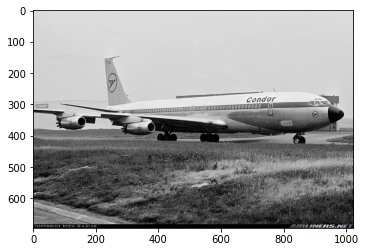

In [ ]:
plt.imshow(plt.imread(manufacturer_df.head(1)['path'].values[0]))

In [ ]:
# La fonction :
# - prend un df (argument)
# - prend une ligne (row : argument, l'indice de la ligne)
# - prend une colonne (target : argument)
# - elle affiche la classe (la valeur de target) et l'image associée, pour la ligne en argument

def show_image(df, row, target):
  """Show an image from an image database, with the associated class.

  Parameters
  ----------
  df (pd.DataFrame): images definition dataframe
  row (int): row index in df of image to be displayed
  target (str): name of the target column

  Returns
  -------
  None
  """
  assert target in df.columns, "Missing target column in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))
  return

Boeing


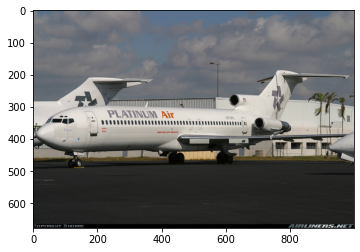

In [ ]:
show_image(manufacturer_df, 42, 'manufacturer')

In [ ]:
manufacturer_df.shape

(3334, 3)

In [ ]:
manufacturer_df.head(3)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978,Boeing,dataset/data/images/0056978.jpg


Boeing


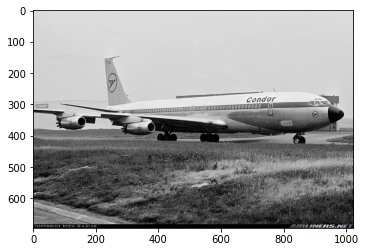

In [ ]:
show_image(manufacturer_df, 0, 'manufacturer')

In [ ]:
plt.imread(manufacturer_df.head(1)['path'].values[0]).shape

(695, 1024, 3)

In [ ]:
manufacturer_df['shape'] = manufacturer_df['path'].apply(lambda p: plt.imread(p).shape)

In [ ]:
# Distribution du nombre de lignes
manufacturer_df['shape'].apply(lambda x: x[0]).value_counts()

695     627
812     310
678     271
679     186
694     107
       ... 
845       1
1180      1
1149      1
885       1
482       1
Name: shape, Length: 404, dtype: int64

In [ ]:
# Distribution du nombre de colonnes
manufacturer_df['shape'].apply(lambda x: x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1375       1
993        1
941        1
1013       1
995        1
Name: shape, Length: 73, dtype: int64

In [ ]:
def load_resize_image(path, height, width):
  """Load an image and resize it to the target size.

  Parameters
  ----------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width
  
  Returns
  -------
  np.array containing resized image
  """
  return np.array(Image.open(path).resize((width, height)))

In [ ]:
manufacturer_df.head(10).apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

0    [[[219, 219, 219], [219, 219, 219], [219, 219,...
1    [[[212, 212, 212], [220, 220, 220], [196, 196,...
2    [[[131, 167, 205], [134, 168, 206], [134, 168,...
3    [[[48, 63, 68], [49, 64, 69], [50, 64, 69], [4...
4    [[[116, 160, 231], [116, 160, 232], [116, 161,...
5    [[[202, 202, 202], [202, 202, 202], [201, 201,...
6    [[[37, 93, 129], [37, 94, 129], [38, 94, 129],...
7    [[[171, 171, 171], [172, 172, 172], [172, 172,...
8    [[[192, 190, 195], [192, 190, 195], [193, 191,...
9    [[[107, 140, 156], [109, 141, 158], [110, 143,...
dtype: object

In [ ]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

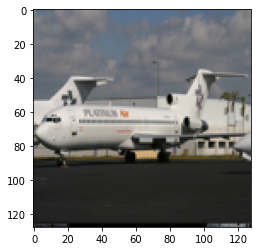

In [ ]:
plt.imshow(manufacturer_df.iloc[42,]['resized_image'])

In [ ]:
def build_classification_model(df: pd.DataFrame, target: str, images: str):
  """Build a TF model using information from target and images columns in dataframe.

  Parameters
  ----------
  df (pd.DataFrame): dataframe with target and images columns
  target (str): column name for target variable
  images (str): column name for images

  Returns
  -------
  TF model built & compiled
  """
  nb_classes = df[target].nunique() # Compute number of classes for output layer
  size = df[images].iloc[0].shape # Compute images size for input layer

  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax')) # output layer with nb_classes

  #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
model = build_classification_model(manufacturer_df, 'manufacturer', 'resized_image')

In [ ]:
# Calcul du nombre de classes pour dimensionner la couche de sortie
nb_classes = manufacturer_df['manufacturer'].nunique()

In [ ]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(IMAGE_WIDTH,
                                                                                IMAGE_HEIGHT,
                                                                                IMAGE_DEPTH)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nb_classes, activation='softmax')) # Couche de sortie à nb_classes

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
manufacturer_df['manufacturer'].value_counts()

Boeing                      733
Airbus                      434
Embraer                     233
McDonnell Douglas           232
de Havilland                167
Canadair                    134
Douglas Aircraft Company    133
Cessna                      133
British Aerospace           133
Fokker                      100
Lockheed Corporation         68
Beechcraft                   67
Saab                         67
Gulfstream Aerospace         67
Dassault Aviation            67
Tupolev                      66
ATR                          66
Panavia                      34
Yakovlev                     34
Lockheed Martin              34
Dornier                      34
Antonov                      34
Bombardier Aerospace         33
Ilyushin                     33
Fairchild                    33
Piper                        33
Cirrus Aircraft              33
Supermarine                  33
Robin                        33
Eurofighter                  33
Name: manufacturer, dtype: int64

In [ ]:
manufacturer_df['manufacturer'].astype('category').cat.codes

0        4
1        4
2        4
3        4
4        4
        ..
3329    28
3330    28
3331    28
3332    28
3333    28
Length: 3334, dtype: int8

In [ ]:
tf.keras.utils.to_categorical(manufacturer_df['manufacturer'].astype('category').cat.codes)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
y = tf.keras.utils.to_categorical(manufacturer_df['manufacturer'].astype('category').cat.codes)

# Build train and test set

In [ ]:
def build_x_and_y(df: pd.DataFrame, target: str, images: str):
  """Build x tensor and y tensor for model fitting.

  Parameters
  ----------
  df (pd.DataFrame): dataframe containing images and target
  target (str): name of target column
  images (str): name of images column

  Returns
  -------
  x (np.array): tensor of x values
  y (np.array): tensor of y values
  """
  x = np.array(df[images].to_list())
  y = tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  return x, y

In [ ]:
# Load train & test dataset
train_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer')
test_df = build_image_database(DATA_DIR / 'images_manufacturer_test.txt', 'manufacturer')

# Load & resize images
train_df['resized_image'] = train_df.apply(lambda r: load_resize_image(r['path'],
                                                                       IMAGE_HEIGHT, IMAGE_WIDTH),
                                           axis=1)
test_df['resized_image'] = test_df.apply(lambda r: load_resize_image(r['path'],
                                                                       IMAGE_HEIGHT, IMAGE_WIDTH),
                                         axis=1)

# Build tensors for training & testing
X_train, y_train = build_x_and_y(train_df, 'manufacturer', 'resized_image')
X_test, y_test = build_x_and_y(test_df, 'manufacturer', 'resized_image')

# Build TF classification model
model = build_classification_model(train_df, 'manufacturer', 'resized_image')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(manufacturer_df[['resized_image', 'manufacturer']], y,
                                                    test_size=0.2, 
                                                    stratify=manufacturer_df['manufacturer'])

In [ ]:
assert X_train.shape[0] + X_test.shape[0] == manufacturer_df.shape[0]
assert y_train.shape[0] + y_test.shape[0] == y.shape[0]

In [ ]:
X_train['manufacturer'].value_counts(normalize=True)[:5]

Boeing               0.219723
Airbus               0.130109
McDonnell Douglas    0.069741
Embraer              0.069741
de Havilland         0.050244
Name: manufacturer, dtype: float64

In [ ]:
X_test['manufacturer'].value_counts(normalize=True)[:5]

Boeing               0.220390
Airbus               0.130435
Embraer              0.070465
McDonnell Douglas    0.068966
de Havilland         0.049475
Name: manufacturer, dtype: float64

In [ ]:
print(X_train['resized_image'].shape, X_test['resized_image'].shape)

(2667,) (667,)


# Train Model

In [ ]:
np.array(X_train['resized_image'].to_list()).shape

(2667, 128, 128, 3)

In [ ]:
np.array(X_test['resized_image'].to_list()).shape

(667, 128, 128, 3)

In [ ]:
%%time
epochs = 5
history = model.fit(np.array(X_train['resized_image'].to_list()), y_train, batch_size=32, epochs=epochs, 
                    validation_data=(np.array(X_test['resized_image'].to_list()), y_test))

Epoch 1/5
84/84 [==============================] - 37s 428ms/step - loss: 14.4847 - accuracy: 0.1849 - val_loss: 2.9175 - val_accuracy: 0.2204
Epoch 2/5
84/84 [==============================] - 36s 425ms/step - loss: 2.9610 - accuracy: 0.2141 - val_loss: 2.9014 - val_accuracy: 0.2204
Epoch 3/5
84/84 [==============================] - 36s 425ms/step - loss: 2.9371 - accuracy: 0.2175 - val_loss: 2.8994 - val_accuracy: 0.2204
Epoch 4/5
84/84 [==============================] - 36s 424ms/step - loss: 2.8835 - accuracy: 0.2163 - val_loss: 2.8409 - val_accuracy: 0.2234
Epoch 5/5
84/84 [==============================] - 36s 427ms/step - loss: 2.7312 - accuracy: 0.2385 - val_loss: 2.7794 - val_accuracy: 0.2309
CPU times: user 6.21 s, sys: 1.09 s, total: 7.3 s
Wall time: 3min 1s


In [ ]:
# https://dpaste.org/VwAF
# A faire une fois pour récupérer les informations sur la TPU

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.95.209.106:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.95.209.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.95.209.106:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with tpu_strategy.scope():
  model = build_classification_model(train_df, 'manufacturer', 'resized_image')

In [ ]:
model = build_classification_model(train_df, 'manufacturer', 'resized_image')

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 124, 124, 32)      2432      
                                                                 
 conv2d_33 (Conv2D)          (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 60, 60, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 58, 58, 64)        18496     
                                                                 
 conv2d_35 (Conv2D)          (None, 56, 56, 64)        36928     
                                                      

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

!rm -rf ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
X_train= np.array(X_train['resized_image'].to_list())

In [ ]:
X_test= np.array(X_test['resized_image'].to_list())

In [ ]:
%%time
epochs = 30
history = model.fit(X_train, y_train, batch_size=96, epochs=epochs, 
                    validation_data=(X_test, y_test),
                    #callbacks=[tensorboard_callback]
                    )

Epoch 1/30
28/28 [==============================] - 36s 1s/step - loss: 32.2057 - accuracy: 0.1526 - val_loss: 3.1098 - val_accuracy: 0.2204
Epoch 2/30
28/28 [==============================] - 34s 1s/step - loss: 3.0529 - accuracy: 0.2115 - val_loss: 2.9165 - val_accuracy: 0.2204
Epoch 3/30
28/28 [==============================] - 34s 1s/step - loss: 2.9838 - accuracy: 0.2066 - val_loss: 2.8928 - val_accuracy: 0.2204
Epoch 4/30
28/28 [==============================] - 34s 1s/step - loss: 2.9597 - accuracy: 0.2070 - val_loss: 2.8935 - val_accuracy: 0.2204
Epoch 5/30
28/28 [==============================] - 35s 1s/step - loss: 2.9569 - accuracy: 0.2081 - val_loss: 2.8925 - val_accuracy: 0.2204
Epoch 6/30
28/28 [==============================] - 35s 1s/step - loss: 2.9419 - accuracy: 0.2148 - val_loss: 2.8892 - val_accuracy: 0.2204
Epoch 7/30
28/28 [==============================] - 34s 1s/step - loss: 2.9466 - accuracy: 0.2122 - val_loss: 2.8924 - val_accuracy: 0.2204
Epoch 8/30
28/28 [=

In [ ]:
model.predict_classes(test_df['resized_image'].iloc[10])

AttributeError: ignored

In [ ]:
X_test[10:20].shape

(10, 128, 128, 3)

Boeing


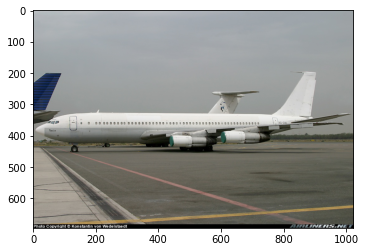

In [ ]:
show_image(test_df, 10, 'manufacturer')

In [ ]:
np.argmax(model.predict(X_test[10:20]), axis=1)

array([ 4,  4,  1,  1, 17,  3,  4,  0,  1,  1])

In [ ]:
train_df['manufacturer'].astype('category').cat.categories

Index(['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing',
       'Bombardier Aerospace', 'British Aerospace', 'Canadair', 'Cessna',
       'Cirrus Aircraft', 'Dassault Aviation', 'Dornier',
       'Douglas Aircraft Company', 'Embraer', 'Eurofighter', 'Fairchild',
       'Fokker', 'Gulfstream Aerospace', 'Ilyushin', 'Lockheed Corporation',
       'Lockheed Martin', 'McDonnell Douglas', 'Panavia', 'Piper', 'Robin',
       'Saab', 'Supermarine', 'Tupolev', 'Yakovlev', 'de Havilland'],
      dtype='object')

In [ ]:
def classify_images(images, model, classes_names=None):
  """Classify images through a TF model.

  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/Keras model
  classes_names: dictionary with names of classes

  Returns
  -------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # argmax returns the index of the max value per row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

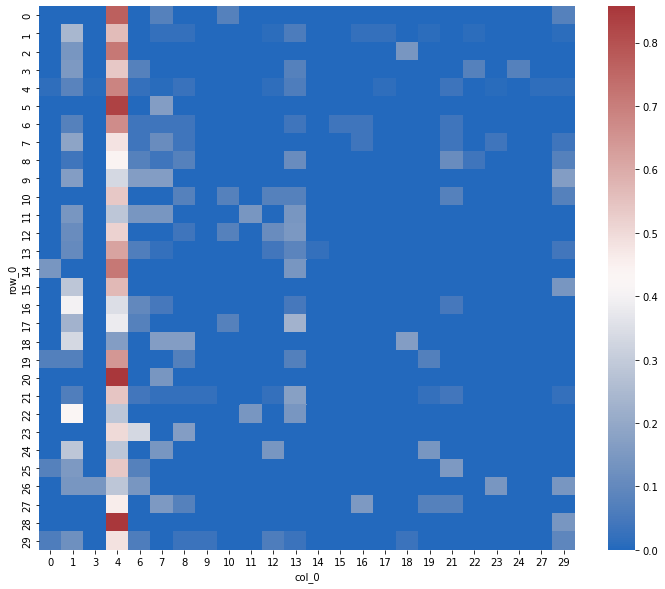

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(np.argmax(y_test, axis=1),
                        classify_images(X_test, model),
                        normalize='index'),
            cmap='vlag',
            ax=ax);

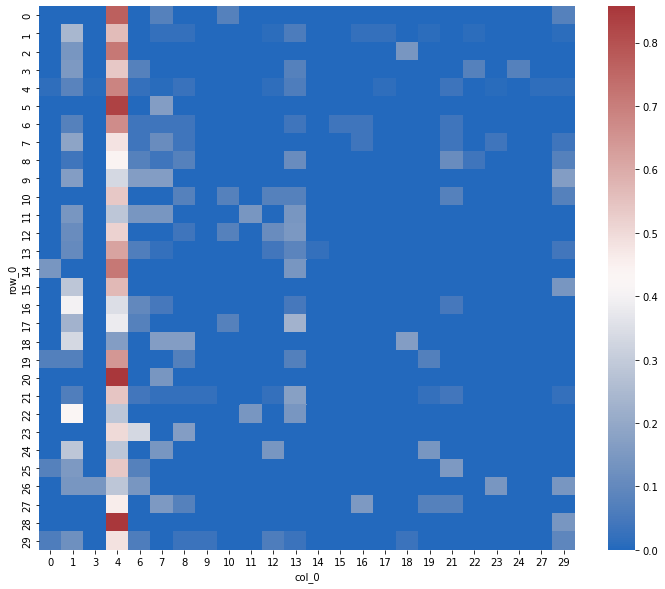

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(np.argmax(y_test, axis=1),
                        classify_images(X_test, model),
                        normalize='index'),
            cmap='vlag',
            ax=ax);

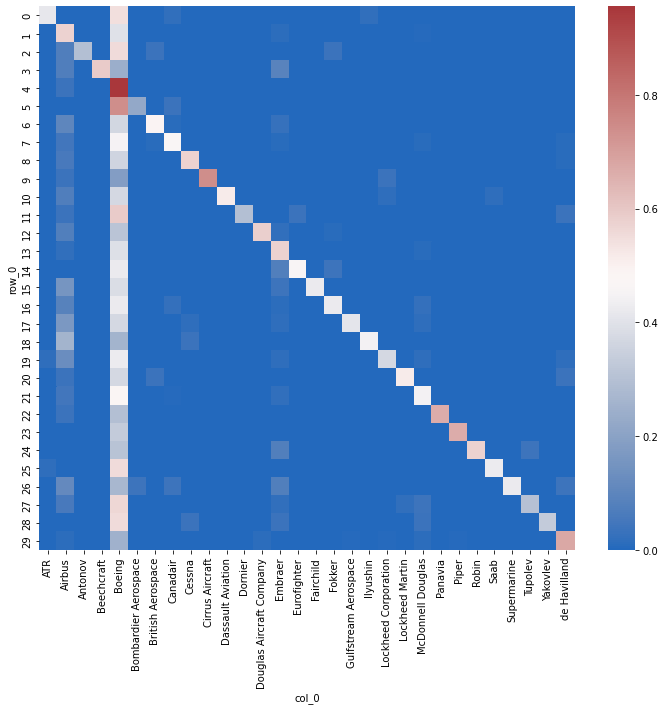

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(np.argmax(y_train, axis=1), classify_images(X_train, model, train_df['manufacturer'].astype('category').cat.categories), normalize='index'),
            cmap='vlag',
            ax=ax);

In [ ]:
model.save(MODEL_DIR / 'my_model.h5')